# Projet Datascientest | Rapport technique

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Promotion** : DST Bootcamp DEC22 \
**Date du document** : 2023/03/06



## Résumé





# Introduction

## Contexte et objectifs

### Étapes

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

### Objectif

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.

### Etapes du projet

Le déroulement du projet suit la statégie suivante :

* Analyse exploratoire
    * Prise en main des données
    * Analyse statistique et feature-engineering
    * Choix des métriques
* Conception de modèles de référence en machine learning
* Conception de modèles deep-learning
    * Traitement des images et du texte
    * Fusion de modèles
* Développement d'un outil intercatif

Le rapport ici présent se compose de parties similaires.

In [72]:
from IPython.display import Image
import pandas as pd

def make_pretty(styler):
    styler.format("{:.2f}")
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="RdYlGn")
    return styler
    

# Analyse exploratoire

L'exploration des données est la première étape de ce projet. 

## Prise en main des données

Les données fournies pour ce challenge sont les suivantes :
* `X_train_update.csv` : données explicatives et textuelles pour l'entraînement
* `X_test_update.csv` : données explicatives et textuelles pour les tests
* `Y_train_CVw08PX.csv` : variable cible pour l'entraînement
* `images/image_train/*.jpg` : images pour l'entraînement
* `images/image_test/*.jpg` :  images pour les tests

> Nous notons que la varible cible de test n'est pas fournie : les observations de tests ne seront donc pas exploitées.

Le jeu d'entrainement se compose a priori de 84 916 observations : des données textuelles ainsi que des images.

### Données d'entrées



#### Textes

Les données `X_train_update.csv` se compose de plusieurs champs : 

* `designation` : titre du produit dans différentes langues (0% de NaNs)
* `description` : description détaillée du produit dans différentes langues (35% de NaNs)
* `productid` : identifiant unique du produit (0% NaNs)
* `imageid` identifiant unique de l'image du produit (0% NaNs)

> Les champs `productid` et `imageid` ne servent qu'à construire le nom du fichier image associé au produit. Ils ne seront donc pas étudiés statistiquement parlant.

#### Images

Chaque produit est associé à une image qui le représente. L'image comporte le produit, généralement photographié sur un fond blanc, mais peut également être complété par une mise scène du produit (jardin, décoration) ou par un support (main portant le produit par exemple). Les images sont en couleur, ont une taille de 500x500 pixels et nous sont fournies au format `.jpg`.

### Données de sorties

Les cibles sont fournies dans le fichier `Y_train_CVw08PX.csv`. A ce stade, nous notons que 27 catégories différentes seront à déterminer.


### Analyse du problème

#### Type de problème

Les observations textuelles et graphiques doivent permettre au modèle d'affecter à chaque observation dont les features sont actuellement (`designation`, `description` , et une image) à une catégorie de produit `prdtypecode`. Cette cible est disponible et se présente sous la forme d'un numéro associé à une catégorie (par exemple `livre`, `tech`, `décoration`, etc.).

Nous avons donc affaire à un problème de catégorisation supervisé. Pour la partie texte, un analyse automatique du langage naturel (*NLP : Natural Langage Processing*) sera à mettre en place.

#### Particularité du problème

La catégorisation se base sur l'apprentissage fait sur les données à notre disposition. Ces données sont de deux types (textuel et graphique). De ce fait :
* les pré-traitements seront différents
* plusieurs modèles seront à concevoir, à entrainer et à faire dialoguer
    * un modèle pour catégoriser le produit en fonction du texte fourni
    * un modèle pour catégrosier le produit en fonction de son image associée
    * une étape de regroupement des prédictions sera à réaliser afin d'obtenir une unique catégorie en fin de process


## Analayse statistique et feature-engineering

### Données d'entrée : textes

#### Nombre de mots

Pour `designation`, les textes sont composés de 4 à 54 mots. La répartition est de type gaussienne : la moyenne se situe à 11.5 mots et l'écart-type est de 6.4 mots. 75% des textes de `designation` ont moins de 14 mots. 

Pour `description`, les textes plus longs et comportent entre 0 (certaines descriptions sont vides) et 2 068 mots. En moyenne, la description se compose d'un texte de 78 mots et 75% des produits sont décrits avec moins de 124 mots. La répartition du nombre de mots suit ici la densité de probabilité d'une loi exponentielle.

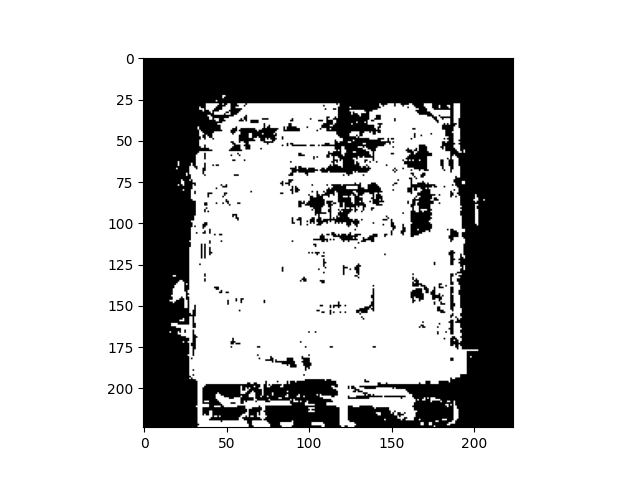

In [73]:
Image(filename="images/mask.png")



Plusieurs actions seront mises en place suite à cette étude

* Les colonnes `designation` et `description` seront fusionnées en une seule colonne `text`
* La colonne `text` sera limitée à 500 mots.    


#### Langues

Intéressons-nous maintenant à la langue. Les colonnes `designation` et `description` contiennent du texte dont la langue peut varier. Le graphique ci-dessous montre la répartition des langues pour la colonne `designation`. La répartition des langues est très hétérogène :
* 81% en français
* 14% en anglais
* 1.5% en allemand
* inférieurs à 1.5% : nl, ca, it, ro, pt, etc...

Le choix a été fait de traduire les textes étrangers vers le français.

TODO : affichger le graphique

### Données d'entrée : images

#### Réduction de dimension

Nous avons noté que beaucoup d'images sont photographiées sur un fond blanc. Ce fond n'apporte en soi aucune information et peut mener à un biais dans notre modèle de classification des images.

TODO : afficher masque et distribution

En faisant une analyse de la variance des pixels sur un échantillon d'images, nous notons que les bordures des images présentent une variance très basses. 

Les images seront rognées de 20% pour supprimer ces marges porteuses de peu d'information avant d'être redimensionnées à la dimension souhaitée.

### Données de sorties

Commme expliqué précédemment, 27 catégories sont présentes dans notre dataset. 

#### Déséquilibre

Le graphique ci-dessous montre le nombre de produits pour chacune des 27 catégories. On remarque facilement que la catégorie "Aquatique" est sur-représentée : elle comporte le double de produits par rapport à la catégorie suivante. On observe également une baisse linéaire du nombre de produits de `Affiche` vers `Accessoire console`. Les catégories de `Cuisine` à `Jeu Console 2` ne présentent que peu d'individus. 

TODO : afficher le graphique

#### Catégories

En visualisant chacune de ces catégories, nous pouvons traduire le numéro de la catégorie à un type de produit.

|Numéro de catégorie| Description|
|-------------------|-------------|
| 10 | Libre |
| 40 | Jeu Console |
| 50 | Accessoire Console|
| 60 | Tech |
| 1140 | Figurine |
| 1160 | Carte Collection |
| 1180 | Jeu Plateau |
| 1280 | Déguisement |
| 1281 | Boite de jeu |
| 1300 | Jouet Tech |
| 1301 | Chaussette |
| 1302 | Gadget |
| 1320 | Bébé |
| 1560 | Salon |
| 1920 | Chambre |
| 1940 | Cuisine |
| 2220 | Jeu Manuel |
| 2060 | Chambre enfant |
| 2220 | Animaux |
| 2280 | Affiche |
| 2403 | Vintage |
| 2462 | Jeu oldschool |
| 2522 | Bureautique |
| 2582 | Décoration |
| 2583 | Aquatique |
| 2585 | Soin et Bricolage |
| 2705 | Livre |
| 2905 | Jeu Console 2 |

## Choix des métriques

Afin de pouvoir qualifier la performance de nos modèles, le choix de la métrique est important. Les notions importantes avant de considérer le choix de la métrique sont les suivantes :

* jeu de données déséquilibré
* forte tendance à l'overfitting
* une erreur de catégorie n'est pas dramatique

Notre choix se porte sur le *weigthed f1-score*, qui considère le déséquilibrage du dataset et fournit un bon compromis entre le *recall* et l'*accuracy*.

Pour rappel, 27 catégories sont à notre disposition. Cela signifie qu'un score de plus de 3.7% est d'ores et déjà supérieur à un modèle purement aléatoire.


### Prévention de l'overfitting

Les modèles implémentés sont sensibles à l'*overtiffing*. Afin de minimiser au maximum ce risque, plusieurs actions ont été mises en place :
* suivi de l'évolution des métriques d'apprentissage via *Tensorboard*
   * 
* ajout des couches `Dropoout` dans nos architectures
* augmentation nos données
* simplification l'architecture des modèles
* utilisation de batches de petite taille
* application d'une cross-validation à 3 échantillons :
    * le modèle est fit sur les données *train*
    * à chaque époque, son évalution est faite sur les données *validation*
    * une fois l'entraînement terminé, le modèle est ensuite globalement étudié sur les données *test*
* appel à des callbacks

Les callbacks sont utiles pour contrôler le déroulement de l'apprentissage. Nous avons mis en place deux méthodes de gestion de l'apprentissage :
* `EarlyStopping` : met fin à l'apprentissage si `val_loss` augmente pendant plus de 5 périodes à partir de la 8ème période
* `ReduceLROnPlateau` : réduit le taux d'apprentissage si `val_loss` stagne sur un plateau pendant plus de 5 périodes

Finalement, le découpage du dataset pour l'entraînement et la prediction est le suivant : 

<figure>
<img src="notebooks/images/decoupage_dataset.png" style="width:100%">
<figcaption align = "center">Découpage du dataset pour l'entraînement, la validation et la prédiction</figcaption>
</figure>

# Modèles de références

## Textes



In [75]:
df = pd.read_csv("../src/models/text/summary_f1-score.csv", index_col="Unnamed: 0")
columns_drop = df.columns[["neural" in column for column in df.columns]]
df.drop(columns_drop, axis=1, inplace=True)
df.style.pipe(make_pretty)

,text_adaboost,text_decision_tree,text_kneighbours,text_random_forest,text_logistic_regression
10,0.00,0.42,0.27,0.48,0.44
40,0.01,0.49,0.34,0.59,0.60
50,0.00,0.60,0.52,0.74,0.70
60,0.00,0.83,0.83,0.86,0.88
1140,0.00,0.61,0.52,0.71,0.69
1160,0.00,0.83,0.72,0.86,0.88
1180,0.00,0.32,0.43,0.57,0.46
1280,0.00,0.52,0.44,0.59,0.62
1281,0.00,0.44,0.31,0.50,0.48
1300,0.85,0.88,0.73,0.85,0.90





## Images


# Modèles de deep-learning

## Textes


### Modèle neuronal dense

Le modèle Neural_Simple se base sur la tokenisation *tfidf* de nos textes. Les entrées sur modèle sont donc une matrice représentant le score-tfidf de chaque mot de chaque texte, si ce mot est dans le vocabulaire de notre tokenizer.


| Layer (type)    |            Output Shape    |          Param |  
|-----------------|----------------------------|-----------------|
| text_dense_1 (Dense)|        (None, 54)     |           270054 |   
| text_drop_1 (Dropout) |      (None, 54)     |           0       |  
| text_output (Dense)|        (None, 27)      |          1485    |  
                                                                 
Total params: 271,539 \
Trainable params: 271,539 \
Non-trainable params: 0 

### Modèle neuronal embedding 

Le modèle *Neural_Embedder*, a la particularité de présenter une couche d'embedding qui nous permet de fournir directement un ensemble de mots à ce réseau de neurones. La vectorisation pour ce réseau gère 50 000 mots et seuls les 500 plus fréquents sont conservés. 

| Layer (type)        |         Output Shape    |           Param |   
|-----------------------|----------------------|--------------------| 
| text_input (Embedding) |      (None, None, 100) |         5000000 |   
| text_average (GlobalAverage Pooling1D) |  (None, 100)      |         0         | 
| text_drop_1 (Dropout)   |    (None, 100)     |          0    |      
| text_dense_1 (Dense)     |   (None, 54)     |           5454   |    
| text_drop_2 (Dropout)   |    (None, 54)     |           0    |      
| text_output (Dense)     |    (None, 27)      |          1485   |    
                                                                 

Total params: 5,006,939 \
Trainable params: 5,006,939 \
Non-trainable params: 0 




In [76]:


df = pd.read_csv("../src/models/text/summary_f1-score.csv", index_col="Unnamed: 0")
columns_drop = df.columns[["neural" not in column for column in df.columns]]
df.drop(columns_drop, axis=1, inplace=True)
df.style.pipe(make_pretty)

,text_neural_embedding,text_neural_simple
10,0.51,0.00
40,0.61,0.00
50,0.76,0.00
60,0.88,0.00
1140,0.77,0.00
1160,0.92,0.00
1180,0.41,0.00
1280,0.64,0.00
1281,0.55,0.00
1300,0.92,0.00





## Images

## Fusion des modèles images et textes

Les deux modèles peuvent fonctionner indépendemment. Cependant, il est possible de mutualiser leurs capacités en fusionnant ces deux modèles en un unique modèle de classification.

### Fusion par concaténation de couches

La fusion est mise en place par concaténation de couches du modèle de texte et du modèle d'image. Cette concaténation est faite sur les avant-dernières couches de nos modèles : ces couches comportent un maximum d'informations. Les autres couches des modèles pré-entrainés sont quant à elles *freezées*. Des couches denses sont ajoutées suite à la concaténation pour obtenir une classification sur 27 classes.



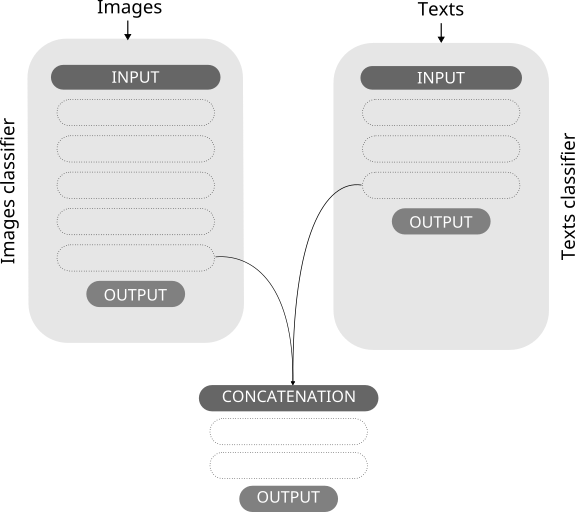

In [77]:
Image(filename="images/fusion_methodology.png")

En appliquant cette méthode à nos modèles `text_neural_embedding` et `image_vgg16`, seulement `XXXXX` paramètres sont à entraîner sur les `XXXXXX` entraînables. Plusieurs configurations ont été testés et leurs scores sont renseignés dans le tableau ci-dessous.


TODO : Tableau des résultats

TODO : Analyse des scores







# Outil interactif

# Conclusion

Le projet est un projet mêlant de l'analyse de texte et du traitement d'images : des notions poussées de deep-learning sont nécessaires à la compréhension et l'implémentation de telles techniques. Cependant, l'état de l'art évolue rapidement et de nouvelles techniques pourraient être mises en place.

Le modèle de texte par exemple pourrait être doté d'une couche d'embedding pré-entrainée, par exemple celle issue de CamemBERT : son entraînement a été effectué sur 138GB de données en français. Sur un tel modèle, l'entraînement des 110 millions de paramètres serait extrêmement coûteux en termes de temps et d'infrastructure. Cette couche remplacerait alors notre couche seulement entrainée sur nos données, et liée à une couche dense de classification pourrait améliorer les scores de notre modèle de texte.

